<a href="https://colab.research.google.com/github/strongeryoung/Oracle_Bio_Service-development/blob/main/LSTM_ecg_classification_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. 데이터셋 다운로드
!wget -O ptbxl.zip https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1.zip
!unzip ptbxl.zip -d ptbxl_dataset

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ptbxl_dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19338_hr.hea  
  inflating: ptbxl_dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.dat  
  inflating: ptbxl_dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.hea  
  inflating: ptbxl_dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.dat  
  inflating: ptbxl_dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.hea  
  inflating: ptbxl_dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.dat  
  inflating: ptbxl_dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.hea  
  inflating: ptbxl_dataset/ptb-xl-a-large-publicly-available-electrocardiog

In [ ]:
!pip install tensorflow sklearn
!pip install wfdb

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 110.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour 

In [ ]:
# 2. 데이터 로드
import pandas as pd
import numpy as np
import wfdb
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# 데이터 로딩
BASE_DIR = 'ptbxl_dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
meta_df = pd.read_csv(BASE_DIR + 'ptbxl_database.csv', index_col='ecg_id')
meta_df['filename_hr'] = meta_df.filename_hr.apply(lambda x: os.path.join(BASE_DIR, x))

scp_codes = pd.read_csv(BASE_DIR + 'scp_statements.csv', index_col=0)

# 클래스 설정
def aggregate_diagnostic(y_dic):
    labels = set()
    for key in y_dic:
        if scp_codes.loc[key].diagnostic_class in ['NORM', 'MI', 'STTC', 'CD', 'HYP']:
            labels.add(scp_codes.loc[key].diagnostic_class)
    return list(labels)

meta_df['diagnostic_superclass'] = meta_df.scp_codes.apply(eval).apply(aggregate_diagnostic)

# 정확히 1개의 클래스를 가진 데이터만 선택
meta_df = meta_df[meta_df['diagnostic_superclass'].map(len) == 1].copy()
meta_df['diagnostic_superclass'] = meta_df['diagnostic_superclass'].apply(lambda x: x[0])

# 클래스별 개수 확인
print("초기 클래스별 데이터 수:")
print(meta_df['diagnostic_superclass'].value_counts())

# 최소 클래스 개수가 536이므로 500으로 설정
sample_per_class = 500

# 클래스당 데이터 개수를 안전하게 추출
meta_df_balanced = pd.concat([
    df.sample(n=min(sample_per_class, len(df)), random_state=42)
    for cls, df in meta_df.groupby('diagnostic_superclass')
]).reset_index(drop=True)

# 최종 클래스별 데이터 수 확인
print("\n균형잡힌 클래스별 데이터 수:")
print(meta_df_balanced['diagnostic_superclass'].value_counts())

초기 클래스별 데이터 수:
diagnostic_superclass
NORM    9083
MI      2538
STTC    2406
CD      1709
HYP      536
Name: count, dtype: int64

균형잡힌 클래스별 데이터 수:
diagnostic_superclass
CD      500
HYP     500
MI      500
NORM    500
STTC    500
Name: count, dtype: int64


In [ ]:
# 3. 12 lead ECG dataset 만들기
def load_12lead_signal(file_path):
    signal, _ = wfdb.rdsamp(file_path)
    return signal[:1000, :].astype(np.float32)  # 2초(500Hz), 12-lead

X = np.array([load_12lead_signal(f) for f in meta_df_balanced['filename_hr']])
y = meta_df_balanced['diagnostic_superclass'].values

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [ ]:
# 4. LSTM 모델 정의 및 학습
import tensorflow as tf

model = tf.keras.Sequential([
    # CNN Layers
    tf.keras.layers.Conv1D(64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Conv1D(64, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),

    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),

    # LSTM Layers
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64),

    # Dense Layers
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # 과적합 방지

    # Output Layer
    tf.keras.layers.Dense(len(np.unique(y_encoded)), activation='softmax')
])

# Optimizer 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 996, 64)        │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 992, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 496, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 494, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 492, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 246, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 246, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,909 (1.08 MB)

 Trainable params: 283,909 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.2049 - loss: 1.6091 - val_accuracy: 0.2125 - val_loss: 1.6071
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.1857 - loss: 1.6068 - val_accuracy: 0.2200 - val_loss: 1.6044
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.2293 - loss: 1.6013 - val_accuracy: 0.2275 - val_loss: 1.5983
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.2176 - loss: 1.5966 - val_accuracy: 0.2625 - val_loss: 1.5893
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.2554 - loss: 1.5798 - val_accuracy: 0.3100 - val_loss: 1.5789
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.2767 - loss: 1.5675 - val_accuracy: 0.2850 - val_loss: 1.5748
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3350 - loss: 1.5407 - val_accuracy: 0.3275 - val_loss: 1.5537
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3211 - loss: 1.5286 - val_accuracy: 0.

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


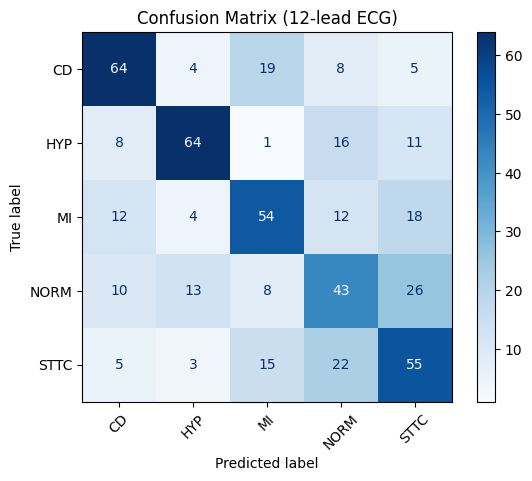

              precision    recall  f1-score   support

          CD       0.65      0.64      0.64       100
         HYP       0.73      0.64      0.68       100
          MI       0.56      0.54      0.55       100
        NORM       0.43      0.43      0.43       100
        STTC       0.48      0.55      0.51       100

    accuracy                           0.56       500
   macro avg       0.57      0.56      0.56       500
weighted avg       0.57      0.56      0.56       500



In [ ]:
# 5. 모델 평가
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 예측
y_pred = np.argmax(model.predict(X_test), axis=1)

# Confusion Matrix 시각화
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (12-lead ECG)")
plt.show()

# 평가 리포트 출력
print(classification_report(y_test, y_pred, target_names=encoder.classes_))